# Task 01: Regional Flash Flood in Germany on 2021-07-14

In a confined stripe from the German-Dutch-Belgium border reaching North East extreme rainfall occurred between 2021-07-14 and 2021-07-15 having led to devastating flash floods in several small river catchments. The BBC gives a good overview of the catastrophy having caused many casualties and severe damage: [BBC News: _Germany floods: Where are the worst-hit areas?_](https://www.bbc.com/news/world-europe-57862894)



<img src="./images/QGIS_p01_Germany_Flood_p01.png" width=1000 /> <br>
_Fig.: RADOLAN spatial precipitation distribution accumulated between 2021-07-13T12:50UTC and 2021-07-15T12:55UTC (two days) <br> and the river catchments affected most by the extreme rain rates. The brightest pink areas showed a precipitation height above 80 mm._






## 1.1 Determine the catchment areas of the rivers Rur, Erft, Ahr, Wupper and Ruhr.

Determine the lengths of the rivers as well their catchment areas (aka river basin area). Fill the values into the CSV file [catchments.csv](catchments.csv) using any text editor. Use Wikipedia to get the information, e.g. for river Rur see 
[this link](https://en.wikipedia.org/wiki/Rur).

Read the file `catchment.csv` into a pandas dataframe. Make the column `River` the index. Rename the columns: "Length (km)" -> length , "Area (km^2)" -> area. Use a dictionary to perform the renaming.

Use matplotlib to create two vertical bar graphs for length and area, respectively.


## 1.2 Determine the cumulative precipitaion at some weather stations in the five catchments

The map below shows the DWD precipitation stations as listed in DWD station description [RR_Stundenwerte_Beschreibung_Stationen.txt](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/RR_Stundenwerte_Beschreibung_Stationen.txt).

Translation:<br>
RR (Regenrate): rain rate<br>
Stundenwerte: hourly values<br>
Beschreibung Stationen: description stations

<img src="./images/QGIS_p03_EZG_HW_Allt_Rain_Gauges.png" width=1000 /><br>
_Fig.: DWD precipitation stations with hourly resolution._
Data taken from DWD's [RR_Stundenwerte_Beschreibung_Stationen.txt](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/RR_Stundenwerte_Beschreibung_Stationen.txt) 


Unfortunately there are inconsistencies in the DWD data availability. According to RR_Stundenwerte_Beschreibung_Stationen.txt the following station should provide annual precipitation values at station 2500:

`02500 20040911 20210724            570     50.3953    6.9896 Kaltenborn, Hohe Acht                    Rheinland-Pfalz`

but the expected zip file containing the measurements for station 2500 as well as meta data is missing in the respective [download area](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/).

### 1.2.1 Analyse precipitation rates for at least one station per each of the five catchment areas.


**Limit the analysis to the the time interval catching the heavy rain events.** The interval `[2021-07-12T12:00+00, 2021-07-15T12:00+00]` should catch the event at all stations. If not then adjust the interval!

Select one precipitation station for each of the five considered catchment areas that meets the following conditions:
* The station is either in the Rur, Erft, Ahr, Wupper or Ruhr catchment,
* the station is in a heavy rain zone (bright pink),
* the station was continuously fully functional in the chosen time interval.

1. Add the selected station IDs for the catchments to the CSV file used before and re-read the extended CSV file to the respective dataframe.
1. **Merge the RR time series of the five selected stations in one pandas data frame named df_RR.** 
1. Plot the information in two ways:
    1. Use the **pandas series plot function** to create vertical bar graphs of rain rates. Plot all five graphs in one diagram. 
    1. Use seaborn to create a **heatmap** of df_RR.

Use the followng function to read a hourly precipitation time series into a pandas dataframe:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Hourly precipitation time series to dataframe
def prec_ts_to_df(fname):
    from datetime import datetime
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="cp1252", 
                     index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, 
                     na_values = [-999.0, -999])

    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    # Add time zone: convert from tz naive datetime to tz aware datetime.
    df.index = df.index.tz_localize(tz ='UTC')
    return(df)

Example for the Station 1303, Essen-Baldeney (Ruhr catchment) and station ID 2497, Kall-Sistig (Rur catchment):

In [3]:
# time interval, create Boolean index! This interval seems to catch the severe rain event.
date_from = pd.to_datetime("2021-07-12T12:00:00UTC")
date_to = pd.to_datetime("2021-07-15T12:00:00UTC")

path_01303 = r"./data/DWD/hourly/precipitation/recent/stundenwerte_RR_01303_akt/"
fname_01303 = r"produkt_rr_stunde_20200121_20210723_01303.txt" # This name changes every day! It depends on when you downloaded the zip file!
pfname_01303 = path_01303 + fname_01303 # path and file name
df_01303 = prec_ts_to_df(pfname_01303)
idx_01303 = (df_01303.index >= date_from) & (df_01303.index <= date_to)

path_02497 = r"./data/DWD/hourly/precipitation/recent/stundenwerte_RR_02497_akt/"
fname_02497 = r"produkt_rr_stunde_20200121_20210723_02497.txt" # This name changes every day! It depends on when you downloaded the zip file!
pfname_02497 = path_02497 + fname_02497 # path and file name
df_02497 = prec_ts_to_df(pfname_02497)
idx_02497 = (df_02497.index >= date_from) & (df_02497.index < date_to)


The `R1` series (dataframe column) contains the rain rate time series! Extract the R1 series of all five dataframes, convert each series to a dataframe containing only R1 with the station ID being the column name and merge the R1 dataframes to one big dataframe with five columns and the same DateTimeIndex. Use an outer join in the merge operation to be save. **This operation is not shown here! We have done it in the lecture!**   

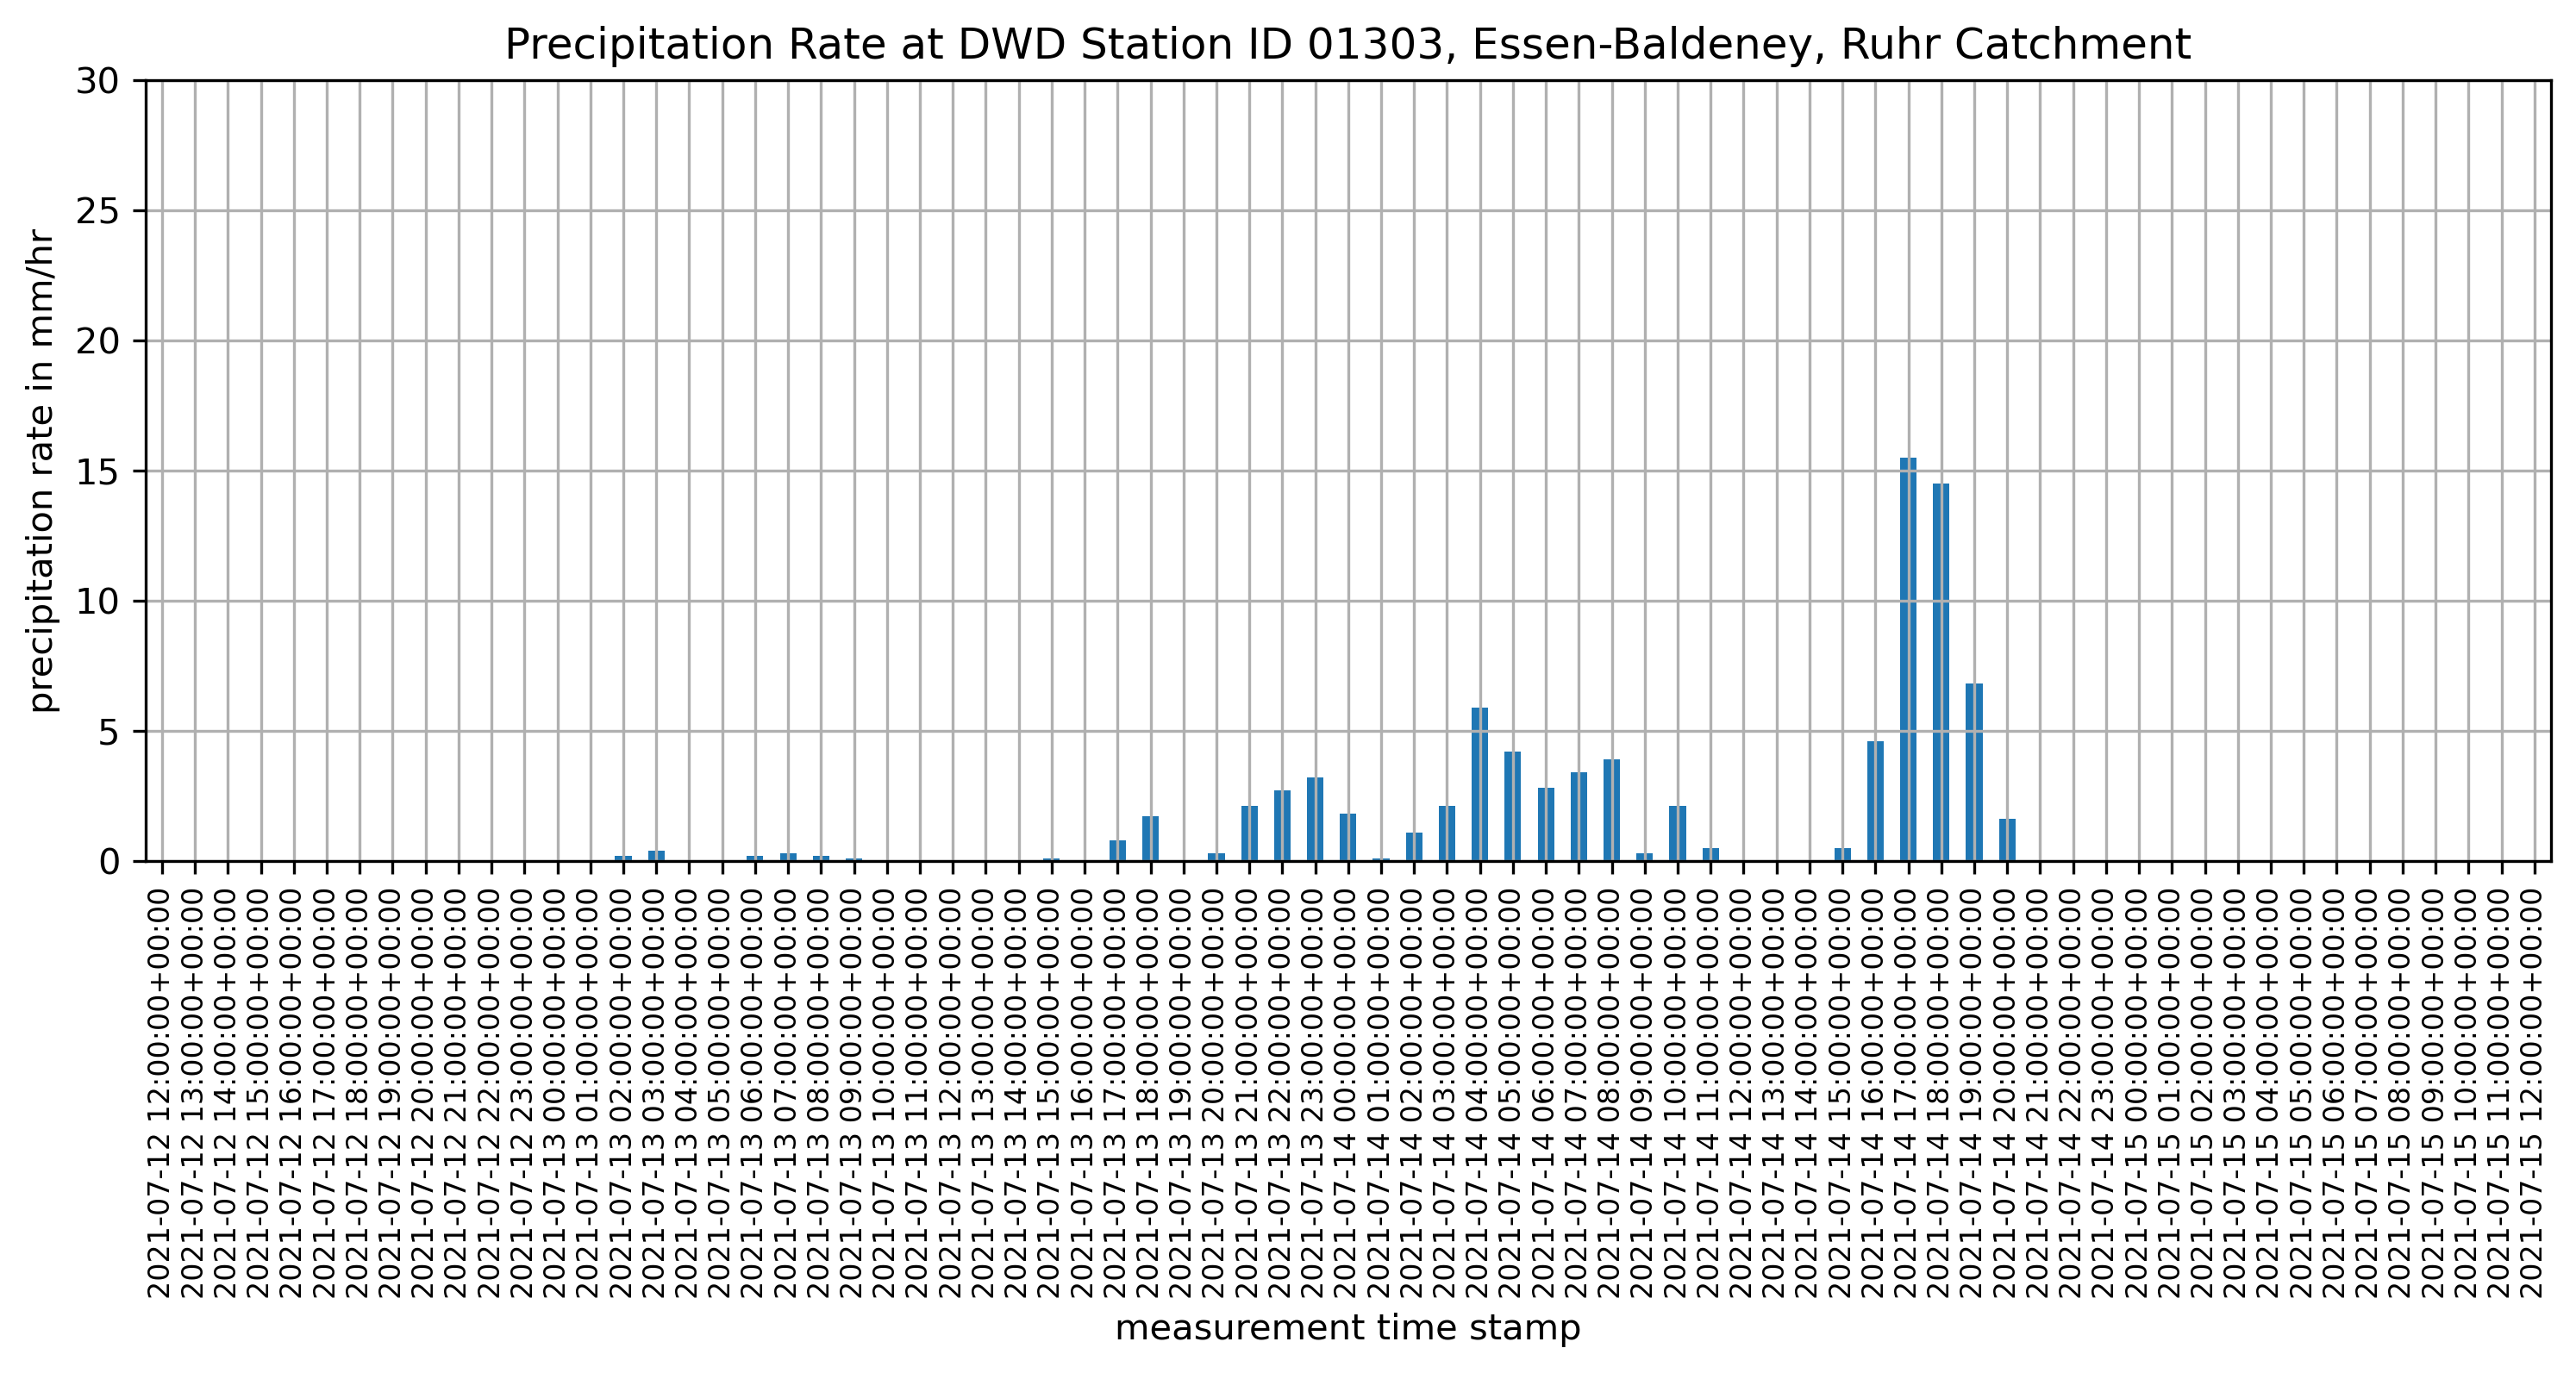

In [4]:
# Example plot of rain rate
fig1, ax1 = plt.subplots(figsize = (12,4), dpi = 300)
df_01303[idx_01303]["r1"].plot.bar(ax = ax1)
ax1.tick_params(axis='x', labelsize=8)
ax1.grid(True)
ax1.set_ylim(0,30)
ax1.set_title("Precipitation Rate at DWD Station ID 01303, Essen-Baldeney, Ruhr Catchment")
ax1.set_ylabel("precipitation rate in mm/hr")
ax1.set_xlabel("measurement time stamp")
plt.show()

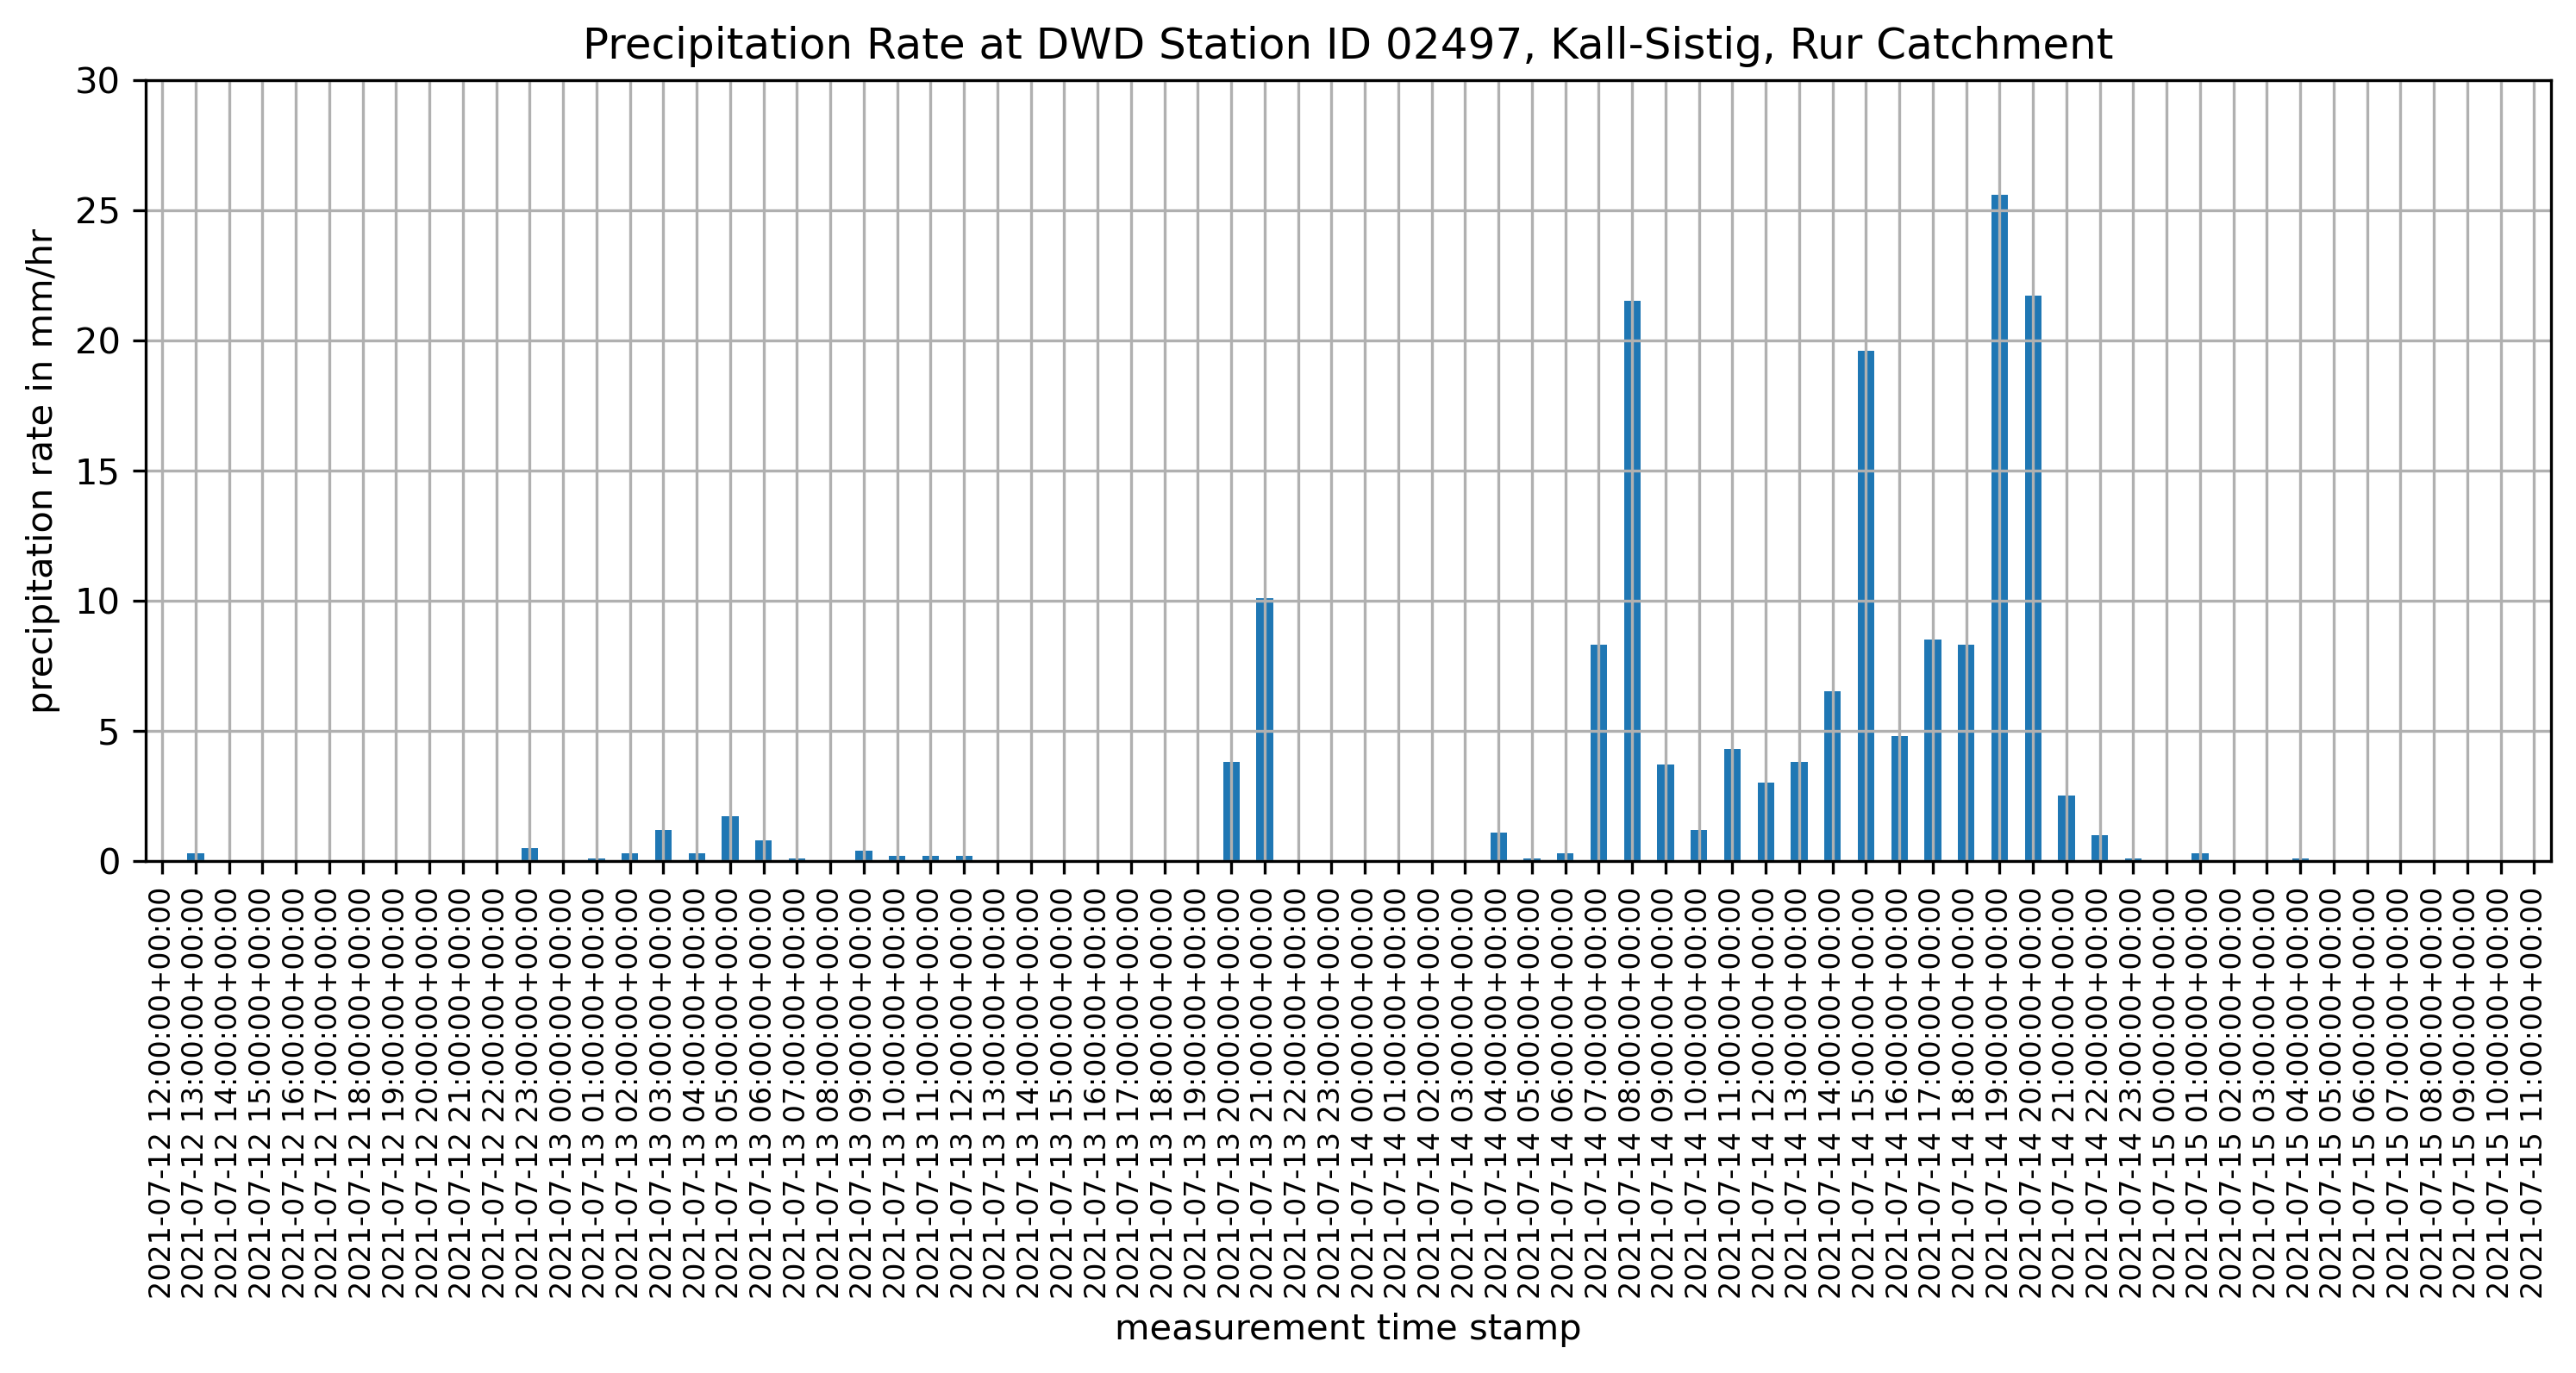

In [5]:
# Example plot of rain rate
fig2, ax2 = plt.subplots(figsize = (12,4), dpi = 300)
df_02497[idx_02497]["r1"].plot.bar(ax = ax2)
ax2.tick_params(axis='x', labelsize=8)
ax2.grid(True)
ax2.set_ylim(0,30)
ax2.set_title("Precipitation Rate at DWD Station ID 02497, Kall-Sistig, Rur Catchment")
ax2.set_ylabel("precipitation rate in mm/hr")
ax2.set_xlabel("measurement time stamp")
plt.show()

### 1.2.2 Determine the cumulative precipitation.

Use the function `cumsum()` to aggregate the precipitation time series gathered in df_RR. You can use either the [pandas version](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html) or the [numpy version](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html). In fact cumsum() integrates the rain rate over time. It yields the growth of precipitation height (collected volume of water) over time. 

1. Plot the five cumulative precipitation sums as line graphs in one figure. 
1. Add another column for the total precipitation height of the event to the CSV file and fill it with any text editor.  
1. Do you see a temporal shift between the step edges of strongly increasing precipitation? Can you order the stations according to the time of onset of heavy rain? Can you derive the motion of the rain event from this information? (I (RB) don't know. I have not tried it, yet.)

### 1.2.3 Compare this event to typical precipitation sums in July as well as annual precipitation.

Use **only one station** of your collection.

Compare the cumulative precipitation height of the analysed heavy rain event (amount of total rain fallen during the event) to the average July precipitation of the years 1961 to 1990 of the selected station. Of course, you have to choose a station from your collection of five stations which provides that historical data over 30 years. Use the monthly precipitation time series from the KL data ensemble: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/monthly/kl/historical/

1. What is the ratio of event and average July precipitation height? 
1. What is the mean annual precipitation at your selected station for the years 1961 to 1990? What is the proportion of the event precipitation sum on the historical long term average?


### 1.2.4 Volume of water accumulated in the catchments during that event

Assume that the cumulative precipitation you determined at the five stations are representative for their whole catchments. How much water in m³ was gathered in the five catchments? Take cumulative precipitation heights of the event at the five stations as well as the catchment areas into account. 


## Background: Meteorological explanation of the heavy rain event.

**TO BE DONE!**

**This background information is not crucial for your assignment.** 

WetterOnline provides an excellent explanation, unfortunately in German, only. 

Because of lack of time I have not transcripted the video to Engish, yet.

Analysis of the heavy rain event having caused the severe flash flood with more than 150 casualties. Verena Leyendecker from WetterOnline, Video (de): https://www.wetteronline.de/wetterticker/59758f5f-c6d0-44a3-8c6f-60ad93fd2d4c

One sequence of maps in the video shows the [equivalent temperature](https://en.wikipedia.org/wiki/Equivalent_temperature).